#Install Libraries and Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark 
!pip install -U -q PyDrive

     |████████████████████████████████| 212.3MB 69kB/s 
     |████████████████████████████████| 204kB 40.7MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=f5ebab69f73f022ad18593fc1d5ce793e44861be154b43f65b9cc71565600c2f
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler,OneHotEncoder, StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
import numpy as np

In [ ]:
!apt update
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [53.9 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [ ]:
spark = SparkSession.builder.appName('modeling').getOrCreate()

In [ ]:
cur_path = '/content/drive/MyDrive/Colab Notebooks/ds5460/final_project/'

In [ ]:
shots_all=pd.read_csv(cur_path+'less_than_two (1).csv')
shots_all.head()

,points,shooter_to_hoop,nearest_def_dist,def_angle,shot_type_num,ball_to_shooter,shooter_id,shooter_x_loc,shooter_y_loc,shot_team_id,ball_x_loc,ball_y_loc,game_id,quarter,game_clock,q_game_clock,join_clock,ball_id,ball_team_id,p1_id,p1_team_id,p1_x_loc,p1_y_loc,p2_id,p2_team_id,p2_x_loc,p2_y_loc,p3_id,p3_team_id,p3_x_loc,p3_y_loc,p4_id,p4_team_id,p4_x_loc,p4_y_loc,p5_id,p5_team_id,p5_x_loc,p5_y_loc,p6_id,...,shot_distance,action_type,eventtime,event_type,game_date,htm,loc_x,loc_y,minutes_remaining,period,player_name,seconds_remaining,shot_made_flag,shot_time,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,vtm,q_event_clock,name,p1_dist_from_ball,p2_dist_from_ball,p3_dist_from_ball,p4_dist_from_ball,p5_dist_from_ball,p6_dist_from_ball,p7_dist_from_ball,p8_dist_from_ball,p9_dist_from_ball,p10_dist_from_ball,p_id_nearest_def,nearest_def_x_loc,nearest_def_y_loc,rim_jump,made_missed,n,pps,points_class
0,0,22.468207,13.670831,20.976720,3,1.999961,202339,3.95743,47.42501,1610612756,3.80772,45.43066,21500126,1,319.57,1319.57,215001261319,-1,-1,2199,1610612756,11.25299,24.40340,200782,1610612756,0.79363,33.96164,202720,1610612756,22.83004,8.76367,202339,1610612756,3.95743,47.42501,202688,1610612756,31.85114,32.19025,1718,...,24,Jump Shot,317,Missed Shot,20151112,PHX,214.6311,16.9240,5,1,Eric Bledsoe,17,0,313.33,3PT Field Goal,Left Side(L),Left Corner 3,24+ ft.,Phoenix Suns,LAC,1317,join_clock_2,22.306450,11.858464,41.307588,1.999961,31.011963,16.872173,29.104928,19.166025,19.676466,11.957578,203085,9.63318,34.98807,jump,0,261,1.015326,0
1,0,7.655767,2.048083,38.634526,2,1.999786,202355,84.55219,31.46674,1610612748,85.88137,32.96087,21500108,2,118.52,2118.52,215001082118,-1,-1,2548,1610612748,71.51432,5.92099,2547,1610612748,86.29922,17.12225,2736,1610612748,93.95483,15.90106,201609,1610612748,64.16046,20.55708,202355,1610612748,84.55219,31.46674,1897,...,10,Turnaround Hook Shot,115,Missed Shot,20151110,MIA,80.5067,32.7000,1,2,Hassan Whiteside,55,0,118.36,2PT Field Goal,Right Side(R),Mid-Range,8-16 ft.,Miami Heat,LAL,2115,join_clock_3,30.619720,15.844131,18.873735,25.013035,1.999786,15.003752,3.856457,19.202419,13.437261,11.481929,201579,84.32840,29.43092,jump,0,132,1.242424,0
2,2,3.700749,3.308324,96.629732,2,1.999475,203083,3.97201,28.43463,1610612765,5.23332,26.88318,21500254,3,626.94,3626.94,215002543626,-1,-1,101141,1610612765,13.42934,19.60519,202704,1610612765,31.96240,24.61587,202694,1610612765,10.69953,2.47405,203484,1610612765,23.16231,5.45276,203083,1610612765,3.97201,28.43463,2772,...,0,Driving Layup Shot,623,Made Shot,20151130,DET,-11.3915,65.6829,10,3,Andre Drummond,23,1,640.00,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,Detroit Pistons,HOU,3623,join_clock_3,10.961016,26.825071,25.013698,27.941217,1.999475,12.793319,9.548265,13.692735,7.969406,3.536200,203991,6.87968,30.01275,rim,1,223,1.004484,2
3,2,3.319835,2.592761,89.052650,2,1.999375,203944,7.88176,22.85256,1610612747,7.99805,24.84855,21500349,4,479.87,4479.87,215003494479,-1,-1,2772,1610612745,10.23175,32.11919,2730,1610612745,5.41683,26.15216,201976,1610612745,18.27971,14.80232,201935,1610612745,10.11215,13.65609,202700,1610612745,9.52597,24.85730,201156,...,0,Driving Layup Shot,479,Made Shot,20151212,HOU,70.4187,21.8644,7,4,Julius Randle,59,1,465.45,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,Los Angeles Lakers,LAL,4479,join_clock_0,7.606025,2.891729,14.374953,11.390372,1.527945,22.837639,0.591538,23.601283,1.999375,25.125611,202700,9.52597,24.85730,rim,1,150,0.826667,2
4,2,8.037922,4.667564,86.547362,2,1.999330,202328,11.92038,29.63015,1610612749,12.59496,27.74806,21500285,1,240.37,1240.37,215002851240,-1,-1,101141,1610612765,25.21203,21.78682,202704,1610612765,14.37442,25.65978,203484,1610612765,8.65706,13.33479,203083,1610612765,9.48749,27.81590,1626169,1610612765,9.60408,39.84053,201564,...,6,Hook Shot,236,Made Shot,20151204,DET,-183.0173,156.8817,3,1,Greg Monroe,56,1,250.89,2PT Field Goal,Center(C),In The Paint (Non

#Feature Selection/Engineering

In [ ]:
shots_all.columns

Index(['points', 'shooter_to_hoop', 'nearest_def_dist', 'def_angle',
       'shot_type_num', 'ball_to_shooter', 'shooter_id', 'shooter_x_loc',
       'shooter_y_loc', 'shot_team_id', 'ball_x_loc', 'ball_y_loc', 'game_id',
       'quarter', 'game_clock', 'q_game_clock', 'join_clock', 'ball_id',
       'ball_team_id', 'p1_id', 'p1_team_id', 'p1_x_loc', 'p1_y_loc', 'p2_id',
       'p2_team_id', 'p2_x_loc', 'p2_y_loc', 'p3_id', 'p3_team_id', 'p3_x_loc',
       'p3_y_loc', 'p4_id', 'p4_team_id', 'p4_x_loc', 'p4_y_loc', 'p5_id',
       'p5_team_id', 'p5_x_loc', 'p5_y_loc', 'p6_id', 'p6_team_id', 'p6_x_loc',
       'p6_y_loc', 'p7_id', 'p7_team_id', 'p7_x_loc', 'p7_y_loc', 'p8_id',
       'p8_team_id', 'p8_x_loc', 'p8_y_loc', 'p9_id', 'p9_team_id', 'p9_x_loc',
       'p9_y_loc', 'p10_id', 'p10_team_id', 'p10_x_loc', 'p10_y_loc',
       'event_id', 'shot_distance', 'action_type', 'eventtime', 'event_type',
       'game_date', 'htm', 'loc_x', 'loc_y', 'minutes_remaining', 'period',
       'play

In [ ]:
keep_columns = ['points', 'shooter_to_hoop', 'nearest_def_dist', 'def_angle', 'shot_type_num', 'action_type', 'shot_made_flag', 'shot_zone_area', 'shot_zone_basic', 'p1_dist_from_ball', 'p2_dist_from_ball',
                'p3_dist_from_ball', 'p4_dist_from_ball', 'p5_dist_from_ball', 'p6_dist_from_ball', 'p7_dist_from_ball','p8_dist_from_ball',
                'p9_dist_from_ball', 'p10_dist_from_ball', 'rim_jump', 'pps']

In [ ]:
final_df=shots_all[keep_columns]
final_df.head()

,points,shooter_to_hoop,nearest_def_dist,def_angle,shot_type_num,action_type,shot_made_flag,shot_zone_area,shot_zone_basic,p1_dist_from_ball,p2_dist_from_ball,p3_dist_from_ball,p4_dist_from_ball,p5_dist_from_ball,p6_dist_from_ball,p7_dist_from_ball,p8_dist_from_ball,p9_dist_from_ball,p10_dist_from_ball,rim_jump,pps
0,0,22.468207,13.670831,20.976720,3,Jump Shot,0,Left Side(L),Left Corner 3,22.306450,11.858464,41.307588,1.999961,31.011963,16.872173,29.104928,19.166025,19.676466,11.957578,jump,1.015326
1,0,7.655767,2.048083,38.634526,2,Turnaround Hook Shot,0,Right Side(R),Mid-Range,30.619720,15.844131,18.873735,25.013035,1.999786,15.003752,3.856457,19.202419,13.437261,11.481929,jump,1.242424
2,2,3.700749,3.308324,96.629732,2,Driving Layup Shot,1,Center(C),Restricted Area,10.961016,26.825071,25.013698,27.941217,1.999475,12.793319,9.548265,13.692735,7.969406,3.536200,rim,1.004484
3,2,3.319835,2.592761,89.052650,2,Driving Layup Shot,1,Center(C),Restricted Area,7.606025,2.891729,14.374953,11.390372,1.527945,22.837639,0.591538,23.601283,1.999375,25.125611,rim,0.826667
4,2,8.037922,4.667564,86.547362,2,Hook Shot,1,Center(C),In The Paint (Non-RA),13.954456,2.743609,14.941533,3.108210,12.456853,27.647770,1.999330,22.116480,8.448041,18.630734,jump,1.117647


##Random Oversampling

I wanted to oversample two-point makes and three-point makes, so that the number of both categories was equal to the number of misses

In [ ]:
indices3 = final_df[final_df['points'] == 3].index
indices2 = final_df[final_df['points'] == 2].index
sample_size = len(final_df[final_df['points'] == 0])
random_indices = np.random.choice(indices3, sample_size, replace=True)
random_indices2 = np.random.choice(indices2, sample_size, replace=True)
three_point_sample = final_df.loc[random_indices]
two_point_sample = final_df.loc[random_indices2]
no_points_sample = final_df[final_df['points'] == 0]
oversampled_df = pd.concat([three_point_sample, two_point_sample, no_points_sample])
len(oversampled_df)

76461

## Add noise to label

Our label only had three values (0,2,3). I added noise, because we wanted to treat this as a regression problem. 

In [ ]:
noise = np.random.normal(0, .1, oversampled_df['points'].size)
oversampled_df['points']=oversampled_df['points'] +noise
oversampled_df.head()

,points,shooter_to_hoop,nearest_def_dist,def_angle,shot_type_num,action_type,shot_made_flag,shot_zone_area,shot_zone_basic,p1_dist_from_ball,p2_dist_from_ball,p3_dist_from_ball,p4_dist_from_ball,p5_dist_from_ball,p6_dist_from_ball,p7_dist_from_ball,p8_dist_from_ball,p9_dist_from_ball,p10_dist_from_ball,rim_jump,pps
5943,2.917145,28.004613,11.480830,6.282993,3,Pullup Jump shot,1,Center(C),Above the Break 3,15.182317,30.195895,24.087636,29.320225,1.636552,24.540192,10.353827,13.143019,24.147176,28.595065,jump,1.132479
22846,2.841541,26.836980,7.807615,28.096315,3,Jump Shot,1,Left Side Center(LC),Above the Break 3,22.685995,25.202246,6.836688,18.453603,8.377096,0.992347,5.924061,27.512686,26.644144,32.071626,jump,1.318386
5049,2.884106,25.610007,14.106644,79.621500,3,Jump Shot,1,Right Side Center(RC),Above the Break 3,25.221693,24.383002,10.711281,1.674116,20.912456,33.710569,52.992226,20.909185,15.390111,13.727658,jump,1.008772
26275,2.979223,23.028015,7.474014,6.322841,3,Jump Shot,1,Left Side(L),Left Corner 3,36.811591,21.789787,25.278179,23.892883,0.858772,30.032637,19.814381,21.125129,14.961263,6.615987,jump,1.173913
9171,2.993567,24.731887,4.600310,32.293850,3,Step Back Jump shot,1,Left Side Center(LC),Above the Break 3,23.825785,15.260138,11.987415,4.368974,27.065458,33.090908,1.506882,40.839907,24.500503,13.205445,jump,1.221053


## Convert from pandas to spark

In [ ]:
sparkDF=spark.createDataFrame(oversampled_df) 
sparkDF.printSchema()
sparkDF.show()

root
 |-- points: double (nullable = true)
 |-- shooter_to_hoop: double (nullable = true)
 |-- nearest_def_dist: double (nullable = true)
 |-- def_angle: double (nullable = true)
 |-- shot_type_num: long (nullable = true)
 |-- action_type: string (nullable = true)
 |-- shot_made_flag: long (nullable = true)
 |-- shot_zone_area: string (nullable = true)
 |-- shot_zone_basic: string (nullable = true)
 |-- p1_dist_from_ball: double (nullable = true)
 |-- p2_dist_from_ball: double (nullable = true)
 |-- p3_dist_from_ball: double (nullable = true)
 |-- p4_dist_from_ball: double (nullable = true)
 |-- p5_dist_from_ball: double (nullable = true)
 |-- p6_dist_from_ball: double (nullable = true)
 |-- p7_dist_from_ball: double (nullable = true)
 |-- p8_dist_from_ball: double (nullable = true)
 |-- p9_dist_from_ball: double (nullable = true)
 |-- p10_dist_from_ball: double (nullable = true)
 |-- rim_jump: string (nullable = true)
 |-- pps: double (nullable = true)

+------------------+-----------

#Index string variables

In [ ]:
columns_lst=["action_type", "shot_zone_area", "shot_zone_basic"]
stages=[]

for column in columns_lst:
    #create a string indexer for those categorical values and assign a new name including the word 'Index'
    stringIndexer = StringIndexer(inputCol = column, outputCol = column + 'Index')

    #append the string Indexer to our list of stages
    stages += [stringIndexer]

pipeline = Pipeline(stages = stages)

pipelineModel = pipeline.fit(sparkDF)

df= pipelineModel.transform(sparkDF)
df.show()

+------------------+------------------+------------------+------------------+-------------+-------------------+--------------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+--------+------------------+----------------+-------------------+--------------------+
|            points|   shooter_to_hoop|  nearest_def_dist|         def_angle|shot_type_num|        action_type|shot_made_flag|      shot_zone_area|  shot_zone_basic| p1_dist_from_ball| p2_dist_from_ball| p3_dist_from_ball| p4_dist_from_ball| p5_dist_from_ball|  p6_dist_from_ball| p7_dist_from_ball| p8_dist_from_ball| p9_dist_from_ball|p10_dist_from_ball|rim_jump|               pps|action_typeIndex|shot_zone_areaIndex|shot_zone_basicIndex|
+------------------+------------------+------------------+------------------+-------------+-------------------+---

#One hot encoding for categorical variables

In [ ]:
encoder = OneHotEncoder(inputCols=["shot_type_num", "action_typeIndex", "shot_zone_areaIndex", "shot_zone_basicIndex"],
                        outputCols=["shot_typeVec", 'actionVec', "areaVec", "zoneVec"])
encoded = encoder.fit(df).transform(df)
encoded.show()

+------------------+------------------+------------------+------------------+-------------+-------------------+--------------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+--------+------------------+----------------+-------------------+--------------------+------------+--------------+-------------+-------------+
|            points|   shooter_to_hoop|  nearest_def_dist|         def_angle|shot_type_num|        action_type|shot_made_flag|      shot_zone_area|  shot_zone_basic| p1_dist_from_ball| p2_dist_from_ball| p3_dist_from_ball| p4_dist_from_ball| p5_dist_from_ball|  p6_dist_from_ball| p7_dist_from_ball| p8_dist_from_ball| p9_dist_from_ball|p10_dist_from_ball|rim_jump|               pps|action_typeIndex|shot_zone_areaIndex|shot_zone_basicIndex|shot_typeVec|     actionVec|      areaVec|      zoneVec|
+-

## Feature vector creation
The number of input columns changed a lot during the project. We wanted to test out different combinations of features to see what would help our model perform the best. Below is the final feature vector we chose. 

In [ ]:
assembler = VectorAssembler(
    inputCols=['shooter_to_hoop', 'nearest_def_dist', 'def_angle', 'actionVec', "shot_typeVec", "zoneVec", 'areaVec', 'pps'],
    outputCol="features")

output = assembler.transform(encoded)
output.select("features", "points").show()

+--------------------+------------------+
|            features|            points|
+--------------------+------------------+
|(68,[0,1,2,4,57,6...|2.9171454381785877|
|(68,[0,1,2,3,57,6...| 2.841540722379262|
|(68,[0,1,2,3,57,6...|2.8841058757732494|
|(68,[0,1,2,3,61,6...|2.9792234886239095|
|(68,[0,1,2,7,57,6...| 2.993566816967534|
|(68,[0,1,2,3,57,6...|3.0901280837822744|
|(68,[0,1,2,3,57,6...|3.0752032322674414|
|(68,[0,1,2,3,61,6...|  3.06853513172596|
|(68,[0,1,2,3,66,6...|2.9743243150182197|
|(68,[0,1,2,3,66,6...|3.0863425821985704|
|(68,[0,1,2,3,57,6...|3.0107515913285496|
|(68,[0,1,2,3,57,6...| 3.022331974086892|
|(68,[0,1,2,4,57,6...|  3.04867859610513|
|(68,[0,1,2,4,57,6...| 2.941830152073567|
|(68,[0,1,2,3,57,6...|3.1932126050915532|
|(68,[0,1,2,4,57,6...| 2.802005545836003|
|(68,[0,1,2,3,57,6...|2.9134584667999586|
|(68,[0,1,2,4,57,6...|  3.10001061890062|
|(68,[0,1,2,3,57,6...|2.9865405580921087|
|(68,[0,1,2,3,57,6...| 2.971716962641897|
+--------------------+------------

Use this dataset for regression

In [ ]:
final_data = output.select("features",'points')

Use this dataset for classification

In [ ]:
final_datac=output.select("features", "shot_made_flag")

## Scale data

Regression Data

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

scalerModel = scaler.fit(final_data)

scaledData = scalerModel.transform(final_data)

Classification Data

In [ ]:
scaledData_class = scalerModel.transform(final_datac)

#Modeling

This is where we split the problem into two type. We started by trying to predict points as a regression problem, but ended up treating it as a clasification problem, trying to predict makes and misses. 

Regression Data

In [ ]:
train_data,test_data = scaledData.randomSplit([0.7,0.3])

In [ ]:
train_datac,test_datac =scaledData_class.randomSplit([0.7,0.3])

## Random Forest Regression

In [ ]:
rf = RandomForestRegressor(labelCol="points", featuresCol="scaledFeatures", maxDepth= 10, maxBins=32, numTrees=20)

In [ ]:
model = rf.fit(train_data)

In [ ]:
model.featureImportances

SparseVector(68, {0: 0.2087, 1: 0.0774, 2: 0.0436, 3: 0.0723, 4: 0.0072, 5: 0.0176, 6: 0.0009, 7: 0.0025, 8: 0.001, 9: 0.0022, 10: 0.0011, 11: 0.0012, 12: 0.0008, 13: 0.0004, 14: 0.0001, 15: 0.0011, 16: 0.0008, 17: 0.0008, 18: 0.0008, 19: 0.0007, 20: 0.0012, 21: 0.0001, 22: 0.0005, 23: 0.0002, 24: 0.0006, 25: 0.0018, 26: 0.0001, 27: 0.0004, 28: 0.0003, 29: 0.0001, 30: 0.0008, 32: 0.0002, 33: 0.0001, 34: 0.0001, 35: 0.0001, 36: 0.0001, 37: 0.0, 38: 0.0002, 39: 0.0004, 40: 0.0001, 41: 0.0001, 42: 0.0, 44: 0.0001, 45: 0.0, 46: 0.0, 47: 0.0, 56: 0.2646, 57: 0.0496, 58: 0.0914, 59: 0.0291, 60: 0.0183, 61: 0.0088, 62: 0.0115, 63: 0.0048, 64: 0.0046, 65: 0.0025, 66: 0.0027, 67: 0.0636})

In [ ]:
predictions = model.transform(test_data)

In [ ]:
predictions.select("prediction", "points", "scaledFeatures").show(5)

+------------------+------------------+--------------------+
|        prediction|            points|            features|
+------------------+------------------+--------------------+
|0.7721095705492085|1.9916213188572816|(68,[0,1,2,3,56,5...|
| 1.095095760516729|2.1032298149834117|(68,[0,1,2,3,56,5...|
|0.8425035763823574|1.8872731849905853|(68,[0,1,2,3,56,5...|
|1.0732231199704343|2.0351579800060065|(68,[0,1,2,3,56,5...|
|1.0732231199704343|2.2073982069563947|(68,[0,1,2,3,56,5...|
+------------------+------------------+--------------------+
only showing top 5 rows



In [ ]:
evaluator = RegressionEvaluator(
    labelCol="points", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse

1.1062427118257836

## Gradient Boosted Regression

In [ ]:
gbt = GBTRegressor(featuresCol="scaledFeatures", labelCol='points', maxDepth=20)

In [ ]:
gb_model = gbt.fit(train_data)

In [ ]:
gb_model.featureImportances

SparseVector(68, {0: 0.191, 1: 0.1938, 2: 0.1883, 3: 0.0184, 4: 0.0056, 5: 0.0024, 6: 0.0014, 7: 0.003, 8: 0.0039, 9: 0.0012, 10: 0.0006, 11: 0.0025, 12: 0.0021, 13: 0.0006, 14: 0.0003, 15: 0.0015, 16: 0.0016, 17: 0.0017, 18: 0.0009, 19: 0.0003, 20: 0.0004, 21: 0.0004, 22: 0.0003, 23: 0.0003, 24: 0.0007, 25: 0.0004, 26: 0.0002, 27: 0.0012, 28: 0.0002, 29: 0.0002, 30: 0.0005, 31: 0.0002, 32: 0.0005, 33: 0.0003, 34: 0.0003, 35: 0.0001, 36: 0.0007, 37: 0.0003, 38: 0.0002, 39: 0.0001, 40: 0.0002, 41: 0.0002, 42: 0.0, 43: 0.0, 44: 0.0002, 45: 0.0001, 46: 0.0001, 47: 0.0001, 48: 0.0, 49: 0.0, 50: 0.0, 51: 0.0, 52: 0.0, 53: 0.0, 56: 0.0518, 57: 0.0046, 58: 0.005, 59: 0.0024, 60: 0.0018, 61: 0.0064, 62: 0.0195, 63: 0.0167, 64: 0.0129, 65: 0.0064, 66: 0.0115, 67: 0.2318})

In [ ]:
predictions = gb_model.transform(test_data)

In [ ]:
predictions.select("prediction", "points", "scaledFeatures").show(5)

+------------------+------------------+--------------------+
|        prediction|            points|            features|
+------------------+------------------+--------------------+
|1.9487824392771063|1.9916213188572816|(68,[0,1,2,3,56,5...|
|1.9770723838050472|2.1032298149834117|(68,[0,1,2,3,56,5...|
| 2.208141202731295|1.8872731849905853|(68,[0,1,2,3,56,5...|
| 2.052412277471519|2.0351579800060065|(68,[0,1,2,3,56,5...|
| 2.052412277471519|2.2073982069563947|(68,[0,1,2,3,56,5...|
+------------------+------------------+--------------------+
only showing top 5 rows



In [ ]:
evaluator = RegressionEvaluator(
    labelCol="points", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse

1.0028549369281836

## Random Forest Classification

In [ ]:
rfc = RandomForestClassifier(labelCol="shot_made_flag", featuresCol="scaledFeatures", maxDepth= 10, maxBins=32, numTrees=20)

In [ ]:
rfc_model = rfc.fit(train_datac)

In [ ]:
rfc_model.featureImportances

SparseVector(68, {0: 0.1851, 1: 0.0927, 2: 0.0281, 3: 0.1594, 4: 0.0168, 5: 0.0417, 6: 0.0021, 7: 0.0033, 8: 0.0038, 9: 0.0059, 10: 0.0094, 11: 0.0016, 12: 0.0074, 13: 0.0014, 14: 0.0043, 15: 0.002, 16: 0.0031, 17: 0.0018, 18: 0.0043, 19: 0.0022, 20: 0.0086, 21: 0.0008, 22: 0.0174, 23: 0.0012, 24: 0.0011, 25: 0.006, 26: 0.0003, 27: 0.0023, 28: 0.0006, 29: 0.0001, 30: 0.0003, 32: 0.0008, 33: 0.002, 34: 0.0013, 35: 0.0003, 37: 0.0003, 38: 0.0003, 39: 0.0001, 41: 0.0024, 42: 0.0001, 43: 0.0, 44: 0.0002, 45: 0.0002, 46: 0.0002, 47: 0.0, 50: 0.0, 56: 0.0858, 57: 0.0337, 58: 0.1114, 59: 0.0632, 60: 0.0346, 61: 0.0147, 62: 0.0025, 63: 0.018, 64: 0.0014, 65: 0.002, 66: 0.0081, 67: 0.0013})

In [ ]:
predictions = rfc_model.transform(test_datac)

In [ ]:
predictions.select("prediction", "shot_made_flag", "scaledFeatures").show(5)

+----------+--------------+--------------------+
|prediction|shot_made_flag|            features|
+----------+--------------+--------------------+
|       1.0|             1|(68,[0,1,2,3],[31...|
|       1.0|             1|(68,[0,1,2,3],[31...|
|       1.0|             1|(68,[0,1,2,3],[31...|
|       1.0|             1|(68,[0,1,2,3],[31...|
|       0.0|             1|(68,[0,1,2,3,56,5...|
+----------+--------------+--------------------+
only showing top 5 rows



In [ ]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("shot_made_flag")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[ 1675,  5926],
       [ 1020, 14237]])

In [ ]:
import seaborn as sn

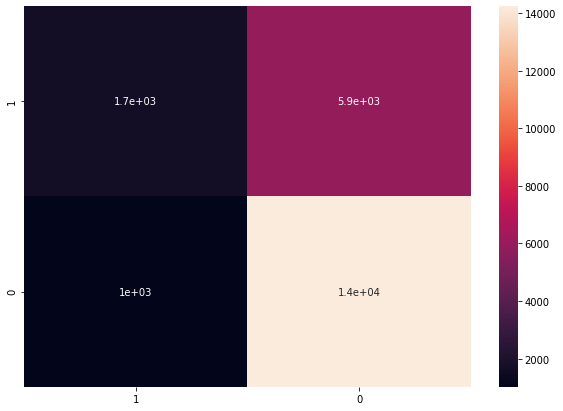

In [ ]:
df_cm = pd.DataFrame(cnf_matrix, index = [i for i in "10"],
                  columns = [i for i in "10"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)